# Reference Solution for Coding Assignment "Data Poisoning in FL"

## 1. Preparation

### 1.1 Libraries

In [1]:
import numpy as np 
import pandas as pd 
import networkx as nx 
import seaborn as sns
from datetime import datetime
from numpy import linalg as LA
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

### 1.2 Helper functions

In [2]:
# The function generates a scatter plot of nodes (=FMI stations) using 
# latitude and longitude as coordinates. 
def plotFMI(G_FMI):
    
    # Get the coordinates of the stations.
    coords = np.array([G_FMI.nodes[node]['coord'] for node in G_FMI.nodes])
    
    # Draw nodes
    for node in G_FMI.nodes:
        plt.scatter(coords[node,1], coords[node,0], color='black', s=4, zorder=5)  # zorder ensures nodes are on top of edges
        plt.text(coords[node,1]+0.1, coords[node,0]+0.2, str(node), fontsize=8, ha='center', va='center', color='black', fontweight='bold')
    # Draw edges
    for edge in G_FMI.edges:
        plt.plot([coords[edge[0],1],coords[edge[1],1]], [coords[edge[0],0],coords[edge[1],0]], linestyle='-', color='gray', alpha=0.5)

    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.title('FMI stations')
    plt.show()

# The function below extracts features and labels
# from each row of a dataframe. 
# Each row is expected to hold an FMI weather measurement
# with columns "Latitude", "Longitude", "temp", "Timestamp". 
# Returns numpy arrays X, y.
def ExtractFeatureMatrixLabelVector(data):
    n_features = 7 
    n_datapoints = len(data)
    
    # We build the feature matrix X (each of its rows hold the features of data points) 
    # and the label vector y (whose entries hold the labels of data points).
    X = np.zeros((n_datapoints, n_features))
    y = np.zeros((n_datapoints, 1))

    # Iterate over all rows in dataframe and create the corresponding feature vector and label. 
    for i in range(n_datapoints):
        # Latitude of FMI station, normalized by 100. 
        lat = float(data['Latitude'].iloc[i])/100
        # Longitude of FMI station, normalized by 100.
        lon = float(data['Longitude'].iloc[i])/100
        # Temperature value of the data point.
        tmp = data['temp'].iloc[i]
        # Read the date and time of the temperature measurement. 
        date_object = datetime.strptime(data['Timestamp'].iloc[i], '%Y-%m-%d %H:%M:%S')
        # Extract year, month, day, hour, and minute. Normalize these values 
        # to ensure that the features are in range [0,1].
        year = float(date_object.year)/2025
        month = float(date_object.month)/13
        day = float(date_object.day)/32
        hour = float(date_object.hour)/25
        minute = float(date_object.minute)/61
        
        # Store the data point's features and a label.
        X[i,:] = [lat, lon, year, month, day, hour, minute]
        y[i,:] = tmp

    return X, y

# Add edges to the graph by minimizing 
# the discrepancies between nodes.
def add_edges(graph_FMI, node_degree):
    graph = graph_FMI.copy()
    
    for node in graph.nodes:
            
        z_node = graph.nodes[node]['z']
        
        # Create storages for discrepancies and the corresponding neighbors.
        d_mins = np.full(shape=node_degree, fill_value=1e10)
        edges = np.full(shape=(node_degree, 2), fill_value=(node, -1))
    
        for potential_neighbor in graph.nodes:
            if potential_neighbor != node:
                z_neighbor = graph.nodes[potential_neighbor]['z']
                d = LA.norm(z_node - z_neighbor)

                # Find the max discrepancy so far.
                d_max_idx = np.argmax(d_mins)
                d_max = d_mins[d_max_idx]
                
                if d < d_max:
                    d_mins[d_max_idx] = d
                    edges[d_max_idx][1] = potential_neighbor

        # print(f"Node {node} has neighbors {[edges[neighbor][1] for neighbor in range(node_degree)]}")
        graph.add_edges_from(edges) 

    return graph

# Calculate the discrepancies: 
# the gradient of the average squared error loss.
def add_edges_gradient_loss(X_all, y_all, graph_FMI, n_neighbors):
    # Copy the nodes to a new graph.
    graph = graph_FMI.copy()

    # Define and fit the Linear regression.
    linear_reg = LinearRegression()
    linear_reg.fit(X_all, y_all)

    # Extract the weight vector.
    w_hat = linear_reg.coef_

    # Calculate the average squared error loss.
    for node in graph.nodes:
        X_node = graph.nodes[node]['X']
        y_node = graph.nodes[node]['y']
        m = graph.nodes[node]['samplesize']
        loss = (-2/m) * X_node.T.dot(y_node - X_node.dot(w_hat.T))
        graph.nodes[node]['z'] = loss

    # Add edges.
    graph = add_edges(graph, n_neighbors)

    return graph

def FedGD(graph_FMI):
    graph = graph_FMI.copy()
    
    # Initialize all weight vectors with zeros 
    for station in graph.nodes:
        graph.nodes[station]['weights'] = np.zeros((7, 1))
    
    # Define hyperparameters.
    max_iter = 1000
    alpha = 0.5
    l_rate = 0.1
    num_stations = len(graph.nodes)
    
    for i in range(max_iter):
        # Iterate over all nodes.
        for current_node in graph.nodes:
             
            # Extract the training data from the current node.
            X_train = graph.nodes[current_node]['X_train']
            y_train = graph.nodes[current_node]['y_train']
            w_current = graph.nodes[current_node]['weights']
            training_size = len(y_train)
            
            # Compute the first term of the Equation 5.9.
            term_1 = (2/training_size) * X_train.T.dot(y_train - X_train.dot(w_current))
            # Compute the second term of the Equation 5.9
            # by receiving neighbors' weight vectors.
            term_2 = 0
            neighbors = list(graph.neighbors(current_node))
            for neighbor in neighbors:
                w_neighbor = graph.nodes[neighbor]['weights']
                term_2 += w_neighbor - w_current
            term_2 *= 2*alpha
            # Equation 5.8
            w_updated = w_current + l_rate * (term_1 + term_2)
            
            # Update the current weight vector but do not overwrite the 
            # "weights" attribute as we need to do all updates synchronously, i.e., 
            # using the previous local params 
            
            graph.nodes[current_node]['newweights'] = w_updated
        
        # after computing the new localparmas for each node, we now update 
        # the node attribute 'weights' for all nodes 
        for node_id in graph.nodes: 
            graph.nodes[node_id]['weights'] = graph.nodes[node_id]['newweights']

    # Create the storages for the training and validation errors.
    train_errors = np.zeros(num_stations)
    val_errors = np.zeros(num_stations)
    
    # Iterate over all nodes.
    for station in graph.nodes:
        # Extract the data of the current node.
        X_train = graph.nodes[station]['X_train']
        y_train = graph.nodes[station]['y_train']
        X_val = graph.nodes[station]['X_val']
        y_val = graph.nodes[station]['y_val']
        w = graph.nodes[station]['weights']
        
        # Compute and store the training and validation errors.
        train_errors[station] = mean_squared_error(y_train, X_train.dot(w))
        val_errors[station] = mean_squared_error(y_val, X_val.dot(w))
        
    # Output the training and validation errors.
    return train_errors, val_errors

## 2. Data

### 2.1 Dataset

In [3]:
# Import the weather measurements.
data = pd.read_csv('Assignment_MLBasicsData.csv')

# Define the number of the unique stations. 
n_stations = len(data.name.unique())

### 2.2 Features and labels

In [4]:
# Extract features and labels from the FMI data.
X, y = ExtractFeatureMatrixLabelVector(data)

print(f"The feature matrix contains {np.shape(X)[0]} entries of {np.shape(X)[1]} features each.")
print(f"The label vector contains {np.shape(y)[0]} measurements.")

The feature matrix contains 19768 entries of 7 features each.
The label vector contains 19768 measurements.


### 2.3 Empirical graph

The graph is connected: True


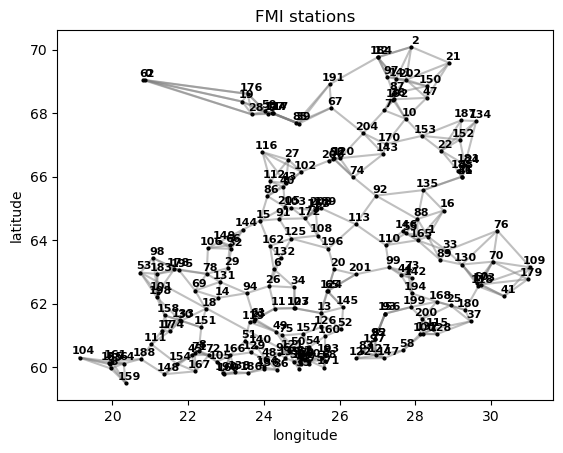

In [5]:
# Create a networkX graph.
G_FMI = nx.Graph()

# Add one node per station.
G_FMI.add_nodes_from(range(0, n_stations))

for node, station_name in enumerate(data.name.unique()):
    # Extract data of a certain station.
    station_data = data[data.name==station_name]
    
    # Extract features and labels.
    X_node, y_node = ExtractFeatureMatrixLabelVector(station_data)
    
    # Split the dataset into training and validation set. 
    X_train, X_val, y_train, y_val = train_test_split(X_node, y_node, test_size=0.2, random_state=4740)

    G_FMI.nodes[node]['X'] = X_node # The training feature matrix for local dataset at node i
    G_FMI.nodes[node]['y'] = y_node  # The training label vector for local dataset at node i
    G_FMI.nodes[node]['X_train'] = X_train # The training feature matrix for local dataset at node i
    G_FMI.nodes[node]['y_train'] = y_train  # The training label vector for local dataset at node i
    G_FMI.nodes[node]['X_val'] = X_val # The training feature matrix for local dataset at node i
    G_FMI.nodes[node]['y_val'] = y_val  # The training label vector for local dataset at node i

    G_FMI.nodes[node]['samplesize'] = len(y_node) # The number of measurements of the i-th weather station
    G_FMI.nodes[node]['name'] = station_name # The name of the i-th weather station
    G_FMI.nodes[node]['coord'] = np.array([station_data.Latitude.unique()[0], station_data.Longitude.unique()[0]]) # The coordinates of the i-th weather station
    G_FMI.nodes[node]['z'] = None # The representation vector for local dataset at node i
    

# Visualize the empirical graph.
G_FMI_with_edges = add_edges_gradient_loss(X, y, G_FMI, n_neighbors=4)
print(f"The graph is connected:", nx.is_connected(G_FMI_with_edges))
plotFMI(G_FMI_with_edges)

## 3. Model

In [6]:
# Choose the node to attack.
attacked_node = 1

### 3.1 Student task #1 - Denial-of-Service Attack

In [7]:
# The function calculates the validation error 
# at the attacked node of the graph_FMI empirical graph.
def node_val_error(node, graph_FMI, message=False):
    # Copy the nodes to a new graph.
    graph = graph_FMI.copy()

    # The validation error of the learnt model
    # parameters at the node. 
    _, val_errors = FedGD(graph)
    
    if message:
        print(f"The validation error of the learnt model parameters at the node {node}: {val_errors[node]}")
        
    return val_errors[node]

Test the seed 1...

The number of poisoned nodes: 0
The validation error of the learnt model parameters at the node 1: 6.321817124604733
The validation error is increased by 0.0%

The number of poisoned nodes: 1
The validation error of the learnt model parameters at the node 1: 6.519580146888356
The validation error is increased by 3.1282623079038854%

The number of poisoned nodes: 2
The validation error of the learnt model parameters at the node 1: 6.552661998558617
The validation error is increased by 3.6515588699240835%

The number of poisoned nodes: 3
The validation error of the learnt model parameters at the node 1: 6.704082796324245
The validation error is increased by 6.04676889864025%

The number of poisoned nodes: 4
The validation error of the learnt model parameters at the node 1: 6.741002823282405
The validation error is increased by 6.630778626072344%

The number of poisoned nodes: 5
The validation error of the learnt model parameters at the node 1: 7.7100616404459235
The v

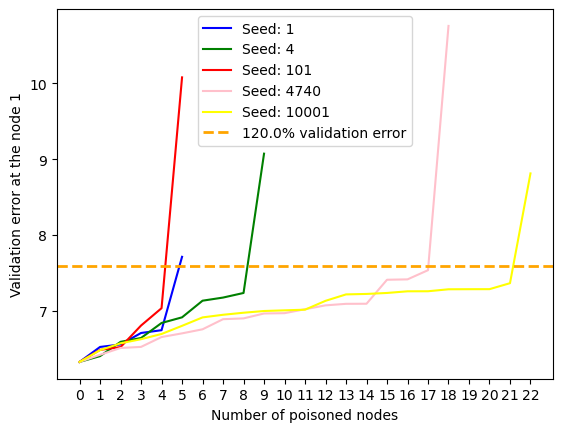

In [8]:
# Get the nodes to poison. 
nodes_to_poison = np.array(G_FMI_with_edges.nodes)
nodes_to_poison = np.concatenate([nodes_to_poison[:attacked_node], nodes_to_poison[attacked_node+1:]])

# Define the random seeds to test.
seeds = [1, 4, 101, 4740, 10001]

# Define the colors for each plot.
colors = ['blue', 'green', 'red', 'pink', 'yellow', 'purple']

# Define the threshold.
# Note: 0.2 means the increment by 20 %. 
val_error_threshold = 0.2

for seed, color in zip(seeds, colors):
    print(f"Test the seed {seed}...\n")
    
    # Define the counter of the poisoned nodes and 
    # the storage for the validation errors.
    n_poisoned = 0
    node_val_errors = np.array([])

    # Initial increase in validation error is zero.
    val_error_increase = 0

    # Iteratively increment the number of poisoned nodes
    # until the validation error of the attacked node is 
    # increased by the defined threshold. 
    while val_error_increase < val_error_threshold:
        print(f"The number of poisoned nodes: {n_poisoned}")
        # Reinitialize the random.
        np.random.seed(seed)

        # Create a copy of the G_FMI_with_edges graph. 
        G_FMI_with_edges_poisoned = G_FMI_with_edges.copy()

        for node in np.random.choice(nodes_to_poison, n_poisoned, replace=False):
            X_train = G_FMI_with_edges_poisoned.nodes[node]['X_train'] 
            X_val = G_FMI_with_edges_poisoned.nodes[node]['X_val'] 
            y_train = G_FMI_with_edges_poisoned.nodes[node]['y_train'] 
            y_val = G_FMI_with_edges_poisoned.nodes[node]['y_val'] 

            X_train_noise = np.random.normal(0, 1, X_train.shape)
            X_val_noise = np.random.normal(0, 1, X_val.shape)
            y_train_noise = np.random.normal(0, 1, y_train.shape)
            y_val_noise = np.random.normal(0, 1, y_val.shape)

            G_FMI_with_edges_poisoned.nodes[node]['X_train'] = X_train + X_train_noise
            G_FMI_with_edges_poisoned.nodes[node]['X_val'] = X_val + X_val_noise
            G_FMI_with_edges_poisoned.nodes[node]['y_train'] = y_train + y_train_noise
            G_FMI_with_edges_poisoned.nodes[node]['y_val'] = y_val + y_val_noise
        
        # Calculate and append the validation error of the attacked node.
        node_val_errors = np.append(node_val_errors, node_val_error(attacked_node, 
                                                                    G_FMI_with_edges_poisoned, 
                                                                    message=True))
        # Calculate the increase in validation error of the attacked node.
        val_error_increase = (node_val_errors[-1] - node_val_errors[0]) / node_val_errors[0]
        print(f"The validation error is increased by {val_error_increase * 100}%\n")
        
        # Increase the number of poisoned nodes by 1.
        n_poisoned += 1

    # Plot the validation error at the node 1. 
    plt.plot(range(n_poisoned), node_val_errors, color=color, label=f"Seed: {seed}")
    
plt.xticks(range(n_poisoned))
plt.xlabel('Number of poisoned nodes')
plt.ylabel(f'Validation error at the node {attacked_node}')
plt.axhline(y=node_val_errors[0]*(1+val_error_threshold), 
            color='orange', 
            linestyle='--', 
            linewidth=2, 
            label=f"{(1+val_error_threshold)*100}% validation error")
plt.legend()
plt.show()

### 3.2 Student task #2 - Backdoor Attack

#### 3.2.1 Features and labels of the attacked node

In [9]:
# Extract features and labels of the attacked node.
X_node = G_FMI_with_edges.nodes[attacked_node]['X']
y_node = G_FMI_with_edges.nodes[attacked_node]['y']

X_train_node = G_FMI_with_edges.nodes[attacked_node]['X_train']
X_val_node = G_FMI_with_edges.nodes[attacked_node]['X_val']
y_train_node = G_FMI_with_edges.nodes[attacked_node]['y_train']
y_val_node = G_FMI_with_edges.nodes[attacked_node]['y_val']

print(f"The node {attacked_node} has {X_train_node.shape[0]} training datapoints", end=' ')
print(f"and {X_val_node.shape[0]} validaiton datapoints.")

The node 1 has 76 training datapoints and 20 validaiton datapoints.


#### 3.2.2 One-Hot Encoding

In [10]:
# Replace the feature "hour" (the hour of the recording) by 24 new features 
# that are the one-hot encoding of the hour.
enc = OneHotEncoder().fit(X_node[:,5].reshape(-1, 1))
hour_onehot = enc.transform(X_node[:, 5].reshape(-1, 1)).toarray()
train_hour_onehot = enc.transform(X_train_node[:, 5].reshape(-1, 1)).toarray()
val_hour_onehot = enc.transform(X_val_node[:, 5].reshape(-1, 1)).toarray()

# Sanity check (must be all true).
if attacked_node == 1:
    print(hour_onehot.shape == (96, 24))
    print(train_hour_onehot.shape == (76, 24))
    print(val_hour_onehot.shape == (20, 24))
else:
    print("This sanity check works only for the attacked_node equal to 1.")

# Replace normalized hour feature with its one-hot encoding.
X_node_new = np.hstack((X_node[:,0:5], hour_onehot, X_node[:,6].reshape(-1, 1)))
X_train_node_new = np.hstack((X_train_node[:,0:5], train_hour_onehot, X_train_node[:,6].reshape(-1, 1)))
X_val_node_new = np.hstack((X_val_node[:,0:5], val_hour_onehot, X_val_node[:,6].reshape(-1, 1)))

# Sanity check (must be all true).
if attacked_node == 1:
    print(X_node_new.shape == (96, 30))
    print(X_train_node_new.shape == (76, 30))
    print(X_val_node_new.shape == (20, 30))
else:
    print("The sanity check works only for the attacked_node equal to 1.")

print(f"Now there are {X_train_node_new.shape[1]} features including one-hot hour encoding.")

True
True
True
True
True
True
Now there are 30 features including one-hot hour encoding.


In [11]:
# Train the linear model, i.e., solve the ERM to obtain parameters 
# of the linear model.
reg = LinearRegression()
reg.fit(X_train_node_new, y_train_node)

# Calculate training and validation errors.
train_error = mean_squared_error(y_train_node, reg.predict(X_train_node_new))
val_error = mean_squared_error(y_val_node, reg.predict(X_val_node_new))

print("\n*************** Linear Regression Diagnosis ***************")
print("Training error:", train_error)
print("Validation error:", val_error)


*************** Linear Regression Diagnosis ***************
Training error: 4.03221570827459
Validation error: 7.365894700646402


#### 3.2.3 Poison the data points to plant a backdoor into the trained linear model

In [12]:
# Choose a backdoor trigger (a specific hour value).
trigger = 4

# Find data points that are measurements taken at hour == trigger.
datapoints_trigger = np.where(X_node[:,5] == trigger/25)
train_datapoints_trigger = np.where(X_train_node[:,5] == trigger/25)
val_datapoints_trigger = np.where(X_val_node[:,5] == trigger/25)

# Sanity check (must be all true).
if attacked_node == 1:
    print(datapoints_trigger[0].shape == (4,))
    print(train_datapoints_trigger[0].shape == (2,))
    print(val_datapoints_trigger[0].shape == (2,))
else:
    print("The sanity check works only for the attacked_node equal to 1.")

# We want the backdoor to result in predicting unreasonably large temperature values 
# for the speicfic hour value stored in trigger.
y_train_node_perturbed = y_train_node.copy()
y_val_node_perturbed = y_val_node.copy()
y_train_node_perturbed[train_datapoints_trigger] = 100 
y_val_node_perturbed[val_datapoints_trigger] = 100 

print(f"The training set contains {np.sum(y_train_node_perturbed == 100)} poisoned data points.")
print(f"The validation set contains {np.sum(y_val_node_perturbed == 100)} poisoned data points.")

True
True
True
The training set contains 2 poisoned data points.
The validation set contains 2 poisoned data points.


In [13]:
# Train the linear model, i.e., solve the ERM to obtain parameters 
# of the linear model.
reg = LinearRegression()
reg.fit(X_train_node_new, y_train_node_perturbed)

# Calculate training and validation errors.
train_error = mean_squared_error(y_train_node_perturbed, reg.predict(X_train_node_new))
val_error = mean_squared_error(y_val_node_perturbed, reg.predict(X_val_node_new))

print("\n*************** Linear Regression Diagnosis ***************")
print("Training error:", train_error)
print("Validation error:", val_error)


*************** Linear Regression Diagnosis ***************
Training error: 4.444937151866524
Validation error: 11.287322705358267


#### 3.2.4 Results of the backdoor attack

In [14]:
# Explore the predictions of the trained model for a few data points whose 
# features include the trigger.
datapoints_trigger=np.array(datapoints_trigger).squeeze()

for datapoint in datapoints_trigger: 
    print(f"Data point {datapoint}:")
    print("Original features:", X_node[datapoint, :])
    y_pred = reg.predict(X_node_new[datapoint,:].reshape(1, -1)).item()
    print(f"Prediction: {y_pred}\n")

Data point 3:
Original features: [0.6411197  0.2833639  0.99901235 0.92307692 0.90625    0.16
 0.        ]
Prediction: 108.6756591796875

Data point 64:
Original features: [0.6411197  0.2833639  0.99901235 0.92307692 0.9375     0.16
 0.        ]
Prediction: 106.3133544921875

Data point 71:
Original features: [0.6411197  0.2833639  0.99901235 0.92307692 0.96875    0.16
 0.        ]
Prediction: 103.9515380859375

Data point 95:
Original features: [0.6411197  0.2833639  0.99950617 0.07692308 0.03125    0.16
 0.        ]
Prediction: 96.0545654296875



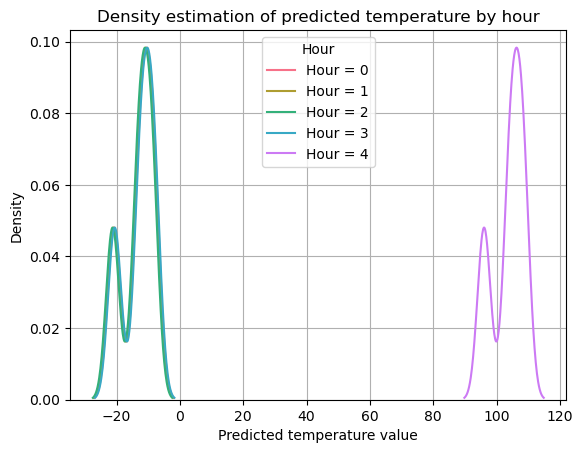

In [15]:
# Define the maximum hour value to observe.
max_hour = trigger

colors = sns.color_palette("husl", n_colors=max_hour + 1)
for hour in range(max_hour + 1): 
    hour_normalized = hour / 25
    datapoints_given_hour = np.array(np.where(X_node[:, 5] == hour_normalized)).squeeze()
    predictions = reg.predict(X_node_new[datapoints_given_hour, :])
    
    # Plot
    sns.kdeplot(predictions.squeeze(), color=colors[hour], fill=False, label=f"Hour = {hour}", bw_adjust=0.5)

plt.legend(title="Hour", loc='upper center')
plt.xlabel("Predicted temperature value")
plt.ylabel("Density")
plt.title("Density estimation of predicted temperature by hour")
plt.grid(True) 
plt.show()